# Pairing

In [2]:
import csv
import pandas as pd
from gensim.models import Word2Vec

from src.data_preprocessing.food_normalization import get_food_descriptors
from src.pairing_rules.generate_pairings import generate_pairs
from src.pairing_rules.elimination import eliminate_not_well_together
from src.pairing_rules.congruent_contrasting import congruent_or_contrasting
from src.pairing_rules.similarity import sort_by_aroma_similarity
from src.pairing_rules.visualizations import make_radio_chart

## Preparation

### Loading files from previous stages

In [3]:
wine_vectors = pd.read_csv("../data/wine_aromas_nonaromas.csv", index_col="Unnamed: 0")
wine_vectors["salt"] = 0
wine_vectors.head()

,aroma,weight,sweet,acid,piquant,fat,bitter,salt
"Aglianico, Italian Red, Aglianico del Vulture, Southern Italy, Italy",[ 1.47843817e-02 -2.56521249e+00 -1.55532622e+...,0.440418,0.559137,0.081831,0.074137,0.517114,0.190725,0
"Aglianico, Italian Red, Irpinia, Southern Italy, Italy",[-4.51575547e-01 -2.69118047e+00 -1.72507966e+...,0.487605,0.474853,0.089575,0.076614,0.455151,0.277241,0
"Aglianico, Italian Red, Taurasi, Southern Italy, Italy",[-1.1400039e-01 -2.5102782e+00 -1.4832231e+00 ...,0.463620,0.724887,0.117762,0.097869,0.526619,0.183798,0
"Alsace white blend, White Blend, Alsace, Alsace, France",[-7.26654351e-01 -2.61081553e+00 -1.22374463e+...,0.549080,0.508619,0.128604,0.303001,0.499623,0.582247,0
"Arneis, Italian White, Roero, Piedmont, Italy",[ 1.2258542 -1.9858316 -1.7651796 2.699851...,0.355460,0.373485,0.163732,0.092648,0.433071,0.389474,0


In [4]:
descriptor_frequencies = pd.read_csv("../data/wine_variety_descriptors.csv", index_col="index")

wine_word2vec_model = Word2Vec.load("../data/word2vec.bin")
word_vectors = wine_word2vec_model.wv

food_nonaroma_infos = pd.read_csv(
    "../data/food_nonaroma_info.csv", index_col="Unnamed: 0"
)

### Food descriptors

In [5]:
food_nonaromas, aroma_embedding = get_food_descriptors(
    ["egg", "mushroom", "tomato"], word_vectors, food_nonaroma_infos
)

In [6]:
food_nonaromas

{'weight': 0.8639302099111775,
 'sweet': 0.5278628464313998,
 'acid': 0.6318579031306629,
 'salt': 0.8186314355947684,
 'piquant': 0.4682579289044633,
 'fat': 0.6018435463439425,
 'bitter': 0.581553618988814}

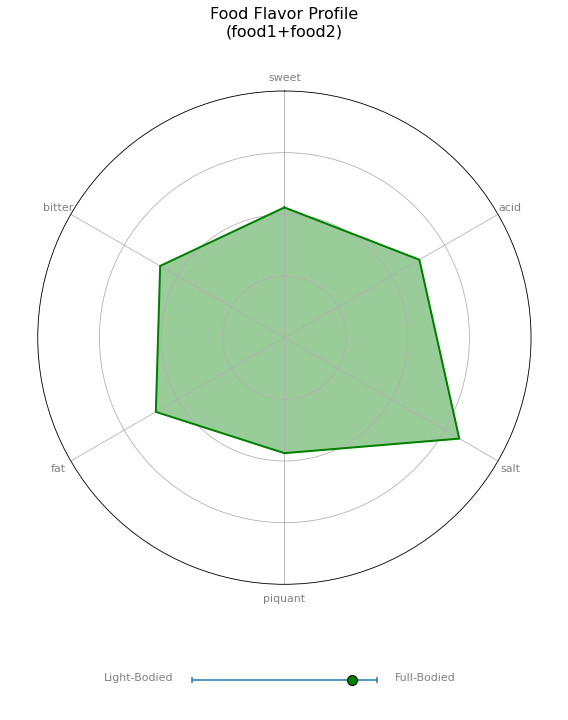

In [2]:
data = {
 'weight': 0.8639302099111775,
 'sweet': 0.5278628464313998,
 'acid': 0.6318579031306629,
 'salt': 0.8186314355947684,
 'piquant': 0.4682579289044633,
 'fat': 0.6018435463439425,
 'bitter': 0.581553618988814
}

title = "Food Flavor Profile"
subtitle = "food1+food2"
color = "green"
make_radio_chart(data, title, subtitle, color)


## Pairing rules

### Anti-rules
The rules that state which nonaromas don't go well together.

In [7]:
wine_recommendations = wine_vectors.copy()
wine_recommendations = eliminate_not_well_together(wine_recommendations, food_nonaromas)

In [8]:
wine_recommendations.head()

,aroma,weight,sweet,acid,piquant,fat,bitter,salt
"Aglianico, Italian Red, Aglianico del Vulture, Southern Italy, Italy",[ 1.47843817e-02 -2.56521249e+00 -1.55532622e+...,0.440418,0.559137,0.081831,0.074137,0.517114,0.190725,0
"Aglianico, Italian Red, Taurasi, Southern Italy, Italy",[-1.1400039e-01 -2.5102782e+00 -1.4832231e+00 ...,0.463620,0.724887,0.117762,0.097869,0.526619,0.183798,0
"Bordeaux-style Red Blend, , Stellenbosch, South Africa",[ 7.2378337e-01 -2.0855939e+00 -1.6394734e+00 ...,0.558099,0.578521,0.681478,0.069242,0.763244,0.294445,0
"Bordeaux-style Red Blend, Fronsac, Bordeaux, France",[ 0.41934884 -2.1652293 -1.8851953 1.260660...,0.374699,0.534043,0.084670,0.098535,0.712220,0.311061,0
"Bordeaux-style Red Blend, Listrac-Médoc, Bordeaux, France",[ 3.8030821e-01 -2.0087905e+00 -1.7155811e+00 ...,0.371584,0.539129,0.275918,0.071945,0.778811,0.220892,0


### Congruent or constrasting

In [9]:
wine_recommendations = congruent_or_contrasting(wine_recommendations, food_nonaromas)

In [10]:
wine_recommendations.value_counts(subset="pairing_type")

pairing_type
               28
contrasting     7
Name: count, dtype: int64

### Sorting by aroma similarity

In [11]:
wine_recommendations = sort_by_aroma_similarity(wine_recommendations, aroma_embedding)
wine_recommendations.sort_values(by="pairing_type", axis=0, ascending=False).head(10)

,aroma,weight,sweet,acid,piquant,fat,bitter,salt,pairing_type,aroma_distance
"Bordeaux-style Red Blend, Lussac Saint-Émilion, Bordeaux, France","[0.20795342, -2.270046, -2.2612236, 0.7207129,...",0.337021,0.557895,0.437668,0.212600,0.810094,0.362087,0,contrasting,0.618869
"Nerello Mascalese, Italian Red, Terre Siciliane, Sicily & Sardinia, Italy","[-0.46742183, -2.09274006, -1.48543894, 1.7116...",0.508429,1.000000,0.084962,0.171461,0.433035,0.278996,0,contrasting,0.601848
"Cabernet Franc, Sonoma, California, US","[0.08412224, -2.732492, -1.4171169, 1.8145885,...",0.518702,0.824200,0.067724,0.089140,0.563305,0.212328,0,contrasting,0.659698
"Montepulciano, Italian Red, Montepulciano dAbruzzo, Central Italy, Italy","[0.22918497, -2.049912, -1.646882, 1.4624332, ...",0.355419,0.822948,0.074513,0.046791,0.610182,0.183859,0,contrasting,0.637084
"Bordeaux-style Red Blend, , Stellenbosch, South Africa","[0.72378337, -2.0855939, -1.6394734, 0.9853870...",0.558099,0.578521,0.681478,0.069242,0.763244,0.294445,0,contrasting,0.618305
"Bordeaux-style Red Blend, Premieres Côtes de Bordeaux, Bordeaux, France","[0.63438463, -1.9826403, -1.8730624, 0.8630985...",0.307068,0.725415,0.129073,0.042895,0.851951,0.107225,0,contrasting,0.632001
"Bordeaux-style Red Blend, Listrac-Médoc, Bordeaux, France","[0.38030821, -2.0087905, -1.7155811, 1.094432,...",0.371584,0.539129,0.275918,0.071945,0.778811,0.220892,0,contrasting,0.624518
"Cabernet Franc, Mendoza, Mendoza Province, Argentina","[0.508443356, -2.72892928, -1.52293897, 1.6994...",0.673964,0.663672,0.059159,0.041735,0.484354,0.299423,0,,0.644125
"Cabernet Sauvignon, Vin de Pays dOc, Languedoc-Roussillon, France","[0.25812152, -2.43739605, -1.32123601, 1.94208...",0.537568,0.552315,0.139370,0.151321,0.508408,0.452553,0,,0.634823
"Aglianico, Italian Red, Aglianico del Vulture, Southern Italy, Italy","[0.0147843817, -2.56521249, -1.55532622, 1.307...",0.440418,0.559137,0.081831,0.074137,0.517114,0.190725,0,,0.636907


## List of k-top pairings

In [12]:
with open("../data/intersection_hub_food.csv", "r") as f:
    csv_reader = csv.reader(f)
    food_list_preprocessed = list(csv_reader)[0]
food_df = pd.read_csv("../data/list_of_foods.csv")
food_list = list(food_df["Food"])

In [28]:
food_list = list(set().union(food_list_preprocessed, food_list))

In [ ]:
generate_pairs(food_list, wine_vectors, word_vectors, food_nonaroma_infos, K=3)

In [30]:
df = pd.DataFrame.from_dict(top_wine_dict, orient="index")
df.head()

,top1,top2,top3
lamb,"Pinot Noir, Pernand-Vergelesses, Burgundy, F...","White Blend, Etna, Sicily & Sardinia, Italy","Red Blends, Red Blends, Ribera del Duero, Nor..."
dill,"Pinot Noir, Pernand-Vergelesses, Burgundy, F...","Dolcetto, Italian Red, Dolcetto dAlba, Piedmo...","Riesling, Niagara Peninsula, Ontario, Canada"
bean,"Pinot Noir, , Niederösterreich, Austria","Bordeaux-style Red Blend, Haut-Médoc, Bordeau...","Cabernet Sauvignon, Coonawarra, South Austral..."
wheat,"Malbec-Cabernet Sauvignon, Bordeaux-style Red ...","Bordeaux-style Red Blend, Médoc, Bordeaux, F...","Bordeaux-style Red Blend, Pomerol, Bordeaux, ..."
pumpkin,"Bordeaux-style Red Blend, Lussac Saint-Émilion...","Riesling, Oregon Other, Oregon, US","Pinot Noir, , Niederösterreich, Austria"
